# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# Задача
Установить взаимосвязь следующих параметров квартиры с её ценой:
- Общая площадь квартиры;
- Количество комнат в квартире;
- Удаленность квартиры от центра;
- Дата размещения объявления;
- Этаж на котором расположена квартира (превый, последний, другой).

Также необходимо установить чем отличаются параметры квартир находящихся в центре Санкт-Петербурга от квартир на его окраинах.

# Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns',None) # Убираем ограничение с ширины отображаемой таблицы

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Первичный осмотр

**Описание данных:**
- total_images — число фотографий квартиры в объявлении
- last_price — цена на момент снятия с публикации
- total_area — площадь квартиры в квадратных метрах (м²)
- first_day_exposition — дата публикации
- rooms — число комнат
- ceiling_height — высота потолков (м)
- floors_total — всего этажей в доме
- living_area — жилая площадь в квадратных метрах (м²)
- floor — этаж
- is_apartment — апартаменты (булев тип)
- studio — квартира-студия (булев тип)
- open_plan — свободная планировка (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- balcony — число балконов
- locality_name — название населённого пункта
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- cityCenters_nearest — расстояние до центра города (м)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)

Спрева посмотрим на типы данных и наличие пропусков с помощью метода `info()`

In [3]:
df_main = pd.read_csv('real_estate_data.csv', sep='\t')
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Из чего можно заметить, что:
- Больше всего отсутсвующих значений в столбцах is_apartment, parks_nearest и ponds_nearest;
- first_day_exposition стоило бы перевести в тип datetime;
- floors_total, balcony, parks_around3000, ponds_around3000 и days_exposition имеют тип float, а им бы больше подошел int.

Взглянем на начало таблицы

In [4]:
df_main.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Ничего неожиданного

Методом describe() посмотрим на характеристики числовых значений в таблице:

In [5]:
df_main.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


Из чего можно заметить такие артефакты как:
- Встречеются квартиры с нулем комнат;
- Встречаются квартиры с высотой потолков в 1 и в 100 метров;
- Встречается квартиры находящиеся на расстоянии в 0 метров от аэропорта.

# Предобработка данных
## Дубликаты

Проверим наличие дубликатов в таблице.

In [6]:
df_main.duplicated().sum()

0

К счастью их нет.

## Пропуски

Посмотрим на распределение пропусков по столбцам.

In [7]:
df_main.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

1. **Первым столбцом** в котором появляются пропуски является **ceiling_height**. Посмотрим для каких квартир характерен этот пропуск:

In [8]:
print(df_main[df_main['ceiling_height'].isna()].shape)
df_main[df_main['ceiling_height'].isna()].head()

(9195, 22)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
5,10,2890000.0,30.4,2018-09-10T00:00:00,1,NaN,12.0,14.4,5,NaN,False,False,9.1,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.3,2017-11-02T00:00:00,1,NaN,26.0,10.6,6,NaN,False,False,14.4,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0


Никаких очевидных причин для отсутствия значений из таблицы не видно. Можно предположить, что люди заполнявшие эту таблицу просто не знали высоту потолка в собстенной квартире.

Заменим отсутсвующие значения на среднее значение высоты потолка для домов предположительно находящигося по одному и тому же адресу. Для этого сгрупируем значения по расстояниям до центра города и до ближайшего аэропорта.

In [9]:
(
    df_main['ceiling_height']
    .fillna(
        df_main.dropna(subset=['cityCenters_nearest', 'airports_nearest'])
        .groupby(['cityCenters_nearest', 'airports_nearest'])['ceiling_height']
        .transform(lambda x: x.mean()), inplace=True)
)
print(df_main[df_main['ceiling_height'].isna()].shape)
df_main[df_main['ceiling_height'].isna()].head()

(5484, 22)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0


Было заполнено приблизительно 4 тысячи пропусков (9195 - 5484 = 3711).

Посмотрим корректно ли поменялись значения.

In [10]:
df_main.loc[[3, 6],:]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,3.00,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
6,6,3700000.0,37.3,2017-11-02T00:00:00,1,2.62,26.0,10.6,6,NaN,False,False,14.4,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0


Замена прошла успешно.

Чтобы не дропать в процессе будущей фильрации 5 тысяч оставшихся потенциально полезных значений заменим их на -1.

In [11]:
df_main['ceiling_height'].fillna(-1, inplace=True)

2. **Второй столбец** с пропусками - **floors_total**.

In [12]:
df_main[df_main['floors_total'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,2.840,NaN,30.80,4,NaN,False,False,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,2.750,NaN,20.75,1,NaN,False,False,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01T00:00:00,2,2.700,NaN,38.40,12,NaN,False,False,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06T00:00:00,3,2.750,NaN,47.10,8,NaN,False,False,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22T00:00:00,1,2.685,NaN,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0


Значения этого столбца пригодятся только для дальнейшего определения, является ли этаж на котором находится квартира последним. Поскольку достаточно точно определить количество этажей в здании руководствуясь оставшимися столбцами таблицы не представляется возможным. То можно оставить там пустое значение.

Таким образом все квартиры находящиеся не на превом этаже с отсутсвующим значением этажности здания, будут определены как квартиры находящиеся на "другом" (не первом и не последнем) этаже.

3. **living_area**

Для заполнения пропусков в living_area найдем среднее отношение жилой площади living_area к общей площади total_area.

Для этого создадим таблицу из непустых значений living_area и total_area, в которую добавим столбец с этношением этих величин. 

In [13]:
df_living_to_tot = df_main[['living_area', 'total_area']].dropna()
df_living_to_tot['living_to_tot_ratio'] = round(df_living_to_tot['living_area']/df_living_to_tot['total_area'], 2)
df_living_to_tot.head(10)

,living_area,total_area,living_to_tot_ratio
0,51.00,108.00,0.47
1,18.60,40.40,0.46
2,34.30,56.00,0.61
4,32.00,100.00,0.32
5,14.40,30.40,0.47
6,10.60,37.30,0.28
8,15.43,33.16,0.47
9,43.60,61.00,0.71
10,20.30,39.60,0.51
11,31.00,44.00,0.70


Чтобы убедиться, что для заполнения пустых значений мы можем использовать среднее отношение, построим гистограмму.

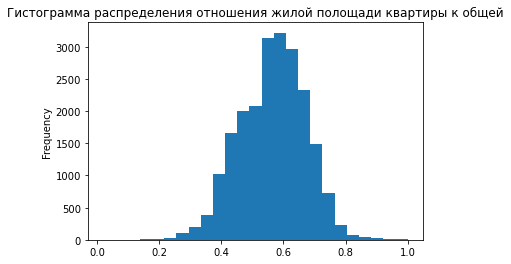

In [14]:
df_living_to_tot['living_to_tot_ratio'].plot.hist(bins=25, title='Гистограмма распределения отношения жилой полощади квартиры к общей')
plt.show()

Видно, что распределение близко к нормальному, а значит можно спокойно использовать среднее значение.

In [15]:
df_main['living_area'].fillna(round(df_main['total_area'] * df_living_to_tot['living_to_tot_ratio'].mean(), 1), inplace=True)

Проверим избавились ли мы от пустых значений в living_area:

In [16]:
df_main['living_area'].isna().sum()

0

4. **is_apartment**

Поскольку этот пункт заполнял человек, то можно предположить, что он оставил его пустым, так как не знал, либо что такое апартаменты, либо является ли его квартира апартаментами. А если это так, то, скорее всего, эта квартира не является апартаментами вовсе. Поэтому заменим все отсутсвующие значения на False.

In [17]:
df_main['is_apartment'].fillna(False, inplace=True)
df_main['is_apartment'].isna().sum()

0

5. **kitchen_area**

Воспользуемся тем же методом что и с living_area.

In [18]:
df_kitchen_to_tot = df_main[['kitchen_area', 'total_area']].dropna()
df_kitchen_to_tot['kitchen_to_tot_ratio'] = round(df_kitchen_to_tot['kitchen_area']/df_kitchen_to_tot['total_area'], 2)
df_kitchen_to_tot.head(10)

,kitchen_area,total_area,kitchen_to_tot_ratio
0,25.00,108.00,0.23
1,11.00,40.40,0.27
2,8.30,56.00,0.15
4,41.00,100.00,0.41
5,9.10,30.40,0.30
6,14.40,37.30,0.39
7,18.90,71.60,0.26
8,8.81,33.16,0.27
9,6.50,61.00,0.11
10,8.50,39.60,0.21


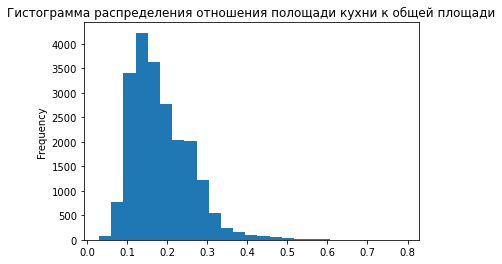

In [19]:
df_kitchen_to_tot['kitchen_to_tot_ratio'].plot.hist(bins=25, title='Гистограмма распределения отношения полощади кухни к общей площади')
plt.show()

В этой гистограмме есть длинный "хвост" из больших значений, так что лучше взять медиану.

In [20]:
df_main['kitchen_area'].fillna(round(df_main['total_area'] * df_kitchen_to_tot['kitchen_to_tot_ratio'].median(), 1), inplace=True)
df_main['kitchen_area'].isna().sum()

0

6. **balcony**

Скорее всего пропуски в этом столбце были оставлены людьми, в квартире которых нет балкона. Так что можно заменить пустые значения на 0.

In [21]:
df_main['balcony'].fillna(0, inplace=True)
df_main['balcony'].isna().sum()

0

7. **Данные о расположении** (locality_name, 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest')

Никакие из данных о расположении нельзя дополнить, основываясь на информации из других столбцов. Значит в них останутся изначальные пустые значения.

8. **days_exposition**

Пустые занчения в этом столбце нельзя подобрать, так так ,скорее всего, отсутсвующее значение означает, что квартиру еще не продали. Так что оставим пропуски.

## Замена типа данных
Приведем first_day_exposition к типу datetime и сократим до дня.

In [22]:
df_main['first_day_exposition'] = pd.to_datetime(df_main['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S').dt.round('1d')

Заменим тип значений в столбце balcony на int.

In [23]:
df_main['balcony'] = df_main['balcony'].astype(int)
df_main.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,-1.00,11.0,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,-1.00,5.0,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,3.00,14.0,89.8,9,False,False,False,27.0,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Замена типа данных в столбцах 'floors_total', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition' на int, осложнена наличием в них пустых значений, которые всегда имеют тип float. Значит, придется оставить их в том виде в котором они есть.

## Артефакты
Квартиры с 0 комнат, скорее всего являются студиями. Проверим предположение.

In [24]:
print('Количество квартир студий среди 0-комнатных квартир =', df_main.query('rooms == 0')['studio'].value_counts()[True])
print('Количество квартир не студий среди 0-комнатных квартир =', df_main.query('rooms == 0')['studio'].value_counts()[False])

Количество квартир студий среди 0-комнатных квартир = 138
Количество квартир не студий среди 0-комнатных квартир = 59


In [25]:
print('Количество квартир студий среди квартир имеющих комнаты =', df_main.query('rooms != 0')['studio'].value_counts()[True])
print('Количество квартир студий среди квартир имеющих комнаты =', df_main.query('rooms != 0')['studio'].value_counts()[False])

Количество квартир студий среди квартир имеющих комнаты = 11
Количество квартир студий среди квартир имеющих комнаты = 23491


Из чего заметно, что многие хозяева квартир студий действительно записали свои квартиры как 0-комнатные. Однако по факту они являются однокомнатными, так что заменим все 0 на 1.

In [26]:
df_main['rooms'].replace(0, 1, inplace=True)

# Расчёты и добавление результатов в таблицу
Добавление цены квадратного метра.

In [27]:
df_main['cost_per_square_m'] = round(df_main['last_price']/df_main['total_area'], 2)

Добавление дня недели, месяца и года публикации объявления.

In [28]:
df_main['day'] = df_main['first_day_exposition'].dt.dayofweek
df_main['month'] = df_main['first_day_exposition'].dt.month
df_main['year'] = df_main['first_day_exposition'].dt.year

Добавление разбивки по этажу квартиры.

In [29]:
df_main['which_floor'] = 'другой'
df_main.loc[df_main['floor'] == 1,'which_floor'] = 'первый'
df_main.loc[df_main['floor'] == df_main['floors_total'],'which_floor'] = 'последний'

Добавление соотношений жилой и общей площади, а также площади кухни к общей.

In [30]:
df_main['living_to_tot'] = round(df_main['living_area']/df_main['total_area'], 2)
df_main['kitchen_to_tot'] = round(df_main['kitchen_area']/df_main['total_area'], 2)

Проверка

In [31]:
df_main.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_square_m,day,month,year,which_floor,living_to_tot,kitchen_to_tot
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,0.47,0.23
1,7,3350000.0,40.4,2018-12-04,1,-1.00,11.0,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,0.46,0.27
2,10,5196000.0,56.0,2015-08-20,2,-1.00,5.0,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,0.61,0.15
3,0,64900000.0,159.0,2015-07-24,3,3.00,14.0,89.8,9,False,False,False,27.0,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,0.56,0.17
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,0.32,0.41


# Исследовательский анализ данных
## Гистограммы для площади, цены, числа комнат, высоты потолков.
Построим гистограмму для общей площади квартир.

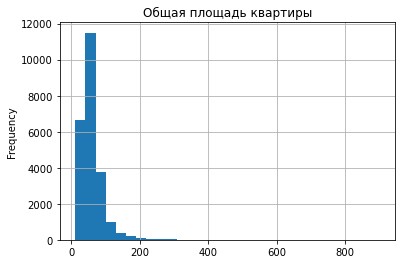

In [32]:
df_main.plot(kind='hist', title='Общая площадь квартиры', y='total_area', bins=30, grid=True, legend=False)
plt.show()

Видно что гистограмма смещена из-за присутсвия малого количества очень больших значений. Для большей информативности сузим область гистограммы.

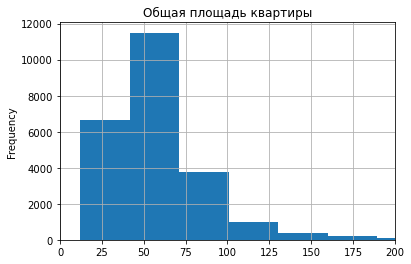

In [33]:
df_main.plot(kind='hist', title='Общая площадь квартиры', y='total_area', xlim=(0, 200), bins=30, grid=True, legend=False)
plt.show()

Все еще недостаточно ясно, можно увеличить точность.

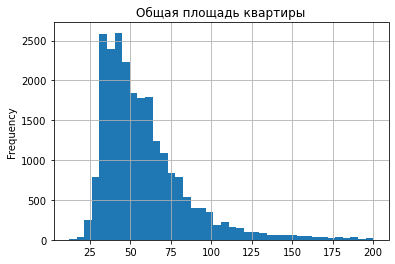

In [34]:
df_main.query('total_area <= 200').plot(kind='hist', title='Общая площадь квартиры', y='total_area', bins=40, grid=True, legend=False)
plt.show()

Теперь видно, что основная масса квартир имеют площадь в диапазоне 30 - 50 м^2.

---
Гистограмма цен.

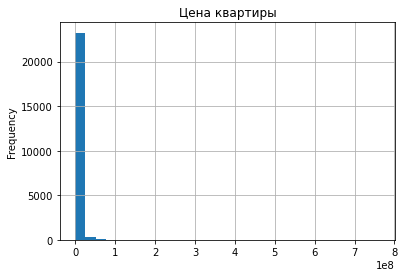

In [35]:
df_main.plot(kind='hist', title='Цена квартиры', y='last_price', bins=30, grid=True, legend=False)
plt.show()

Ограничим область до от 0 до 20.000.000

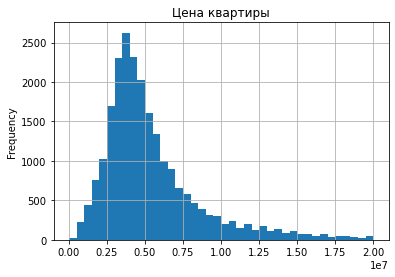

In [36]:
df_main.query('last_price <= 20000000').plot(kind='hist', title='Цена квартиры', y='last_price', bins=40, grid=True, legend=False)
plt.show()

Из чего видно, что оснавная масса квартир имеет стоимость от 3.000.000 до 5.000.000 руб

---
Гистограмма числа комнат.

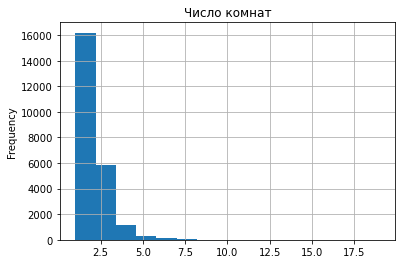

In [37]:
df_main.plot(kind='hist', title='Число комнат', y='rooms', bins=15, grid=True, legend=False)
plt.show()

Ограничим до 7 комнат.

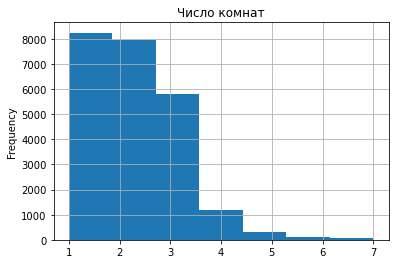

In [38]:
df_main.query('rooms <= 7').plot(kind='hist', title='Число комнат', y='rooms', bins=7, grid=True, legend=False)
plt.show()

Из чего видно, что основную массу составляют 1, 2 и 3-комнатные квартиры.

---
Гисограмма высоты потолков.

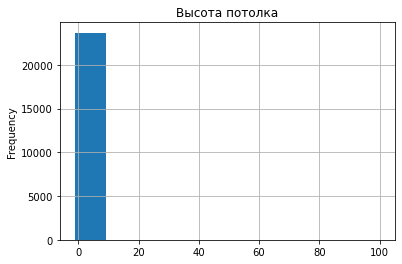

In [39]:
df_main.plot(kind='hist', title='Высота потолка', y='ceiling_height', bins=10, grid=True, legend=False)
plt.show()

Ограничим до 5 метров.

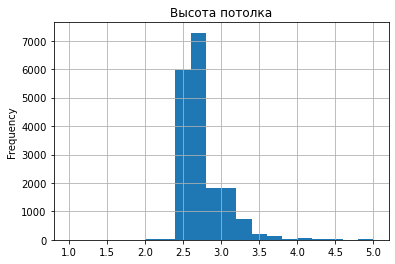

In [40]:
df_main.query('0 <= ceiling_height <= 5').plot(kind='hist', title='Высота потолка', y='ceiling_height', bins=20, grid=True, legend=False)
plt.show()

Видно, что основная масса приходится на высоту от 2.5 до 2.75 метров.

## Гистограмма для времени продажи.

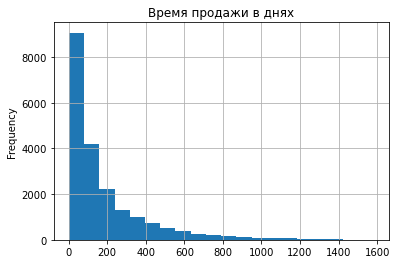

In [41]:
df_main.plot(kind='hist', title='Время продажи в днях', y='days_exposition', bins=20, grid=True, legend=False)
plt.show()

Видно, что время продажи имеет максимальную встречаемость в области от 0 до 100 дней, а затем встречаемость плавно убывает.

Взглянем на область от 0 до 200 дней.

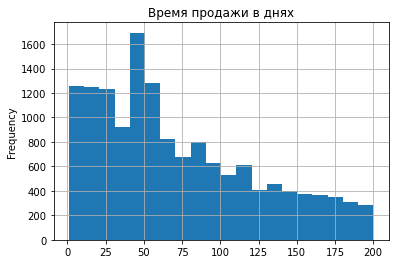

In [42]:
df_main.query('days_exposition < = 200').plot(kind='hist', title='Время продажи в днях', y='days_exposition', bins=20, grid=True, legend=False)
plt.show()

Теперь лучше видно, что максимум находится в области 50 дней.

In [43]:
days_exposition_mean = df_main['days_exposition'].mean()
days_exposition_med = df_main['days_exposition'].median()
print('Среднее время продажи: ', days_exposition_mean)
print('Медиана времени продажи: ', days_exposition_med)

Среднее время продажи:  180.88863436982163
Медиана времени продажи:  95.0


Видно большое различие между средним и медианой, что можно было предсказать из гистограммы, так как у гистограммы имеется длинный "хвост" в области больших значений.

Для определения границы слишком малых и слишком больших значений возьмем 2.5% и 97.5% перцентиль. Для того чтобы у нас осталось 95% значений.

In [44]:
df_main['days_exposition'].quantile(0.025)

6.000000000000001

In [45]:
df_main['days_exposition'].quantile(0.975)

846.0

Таким образом, будем считать, что срок продажи дольше 846 дней, то он является необычайно долгим.

Очень быструю продажу примем как продажу произошедшую менее чем за 6 дней.

## Редкие и выбивающиеся значения.
Уберем выбивающиеся значения для столбцов с площадью, ценой, числом комнат и высотой потолков руководствуясь гистограммами из прошлых пунктов.

Останутся квартиры с:
- площадью от 20 до 175 м^2;
- ценой от 500.000 до 17.500.000 руб;
- количеством комнат от 1 до 6;
- высотой потолка от 2 до 4 м (и -1 м, которые будут убраны из финальных графиков).

In [46]:
df_filtered = df_main.query('(20 <= total_area <= 175) and (500000 <= last_price <= 17500000) and (1 <= rooms <= 6) and ((2 <= ceiling_height <= 4) or (ceiling_height == -1))')

In [47]:
print('Размер оригинального датасета =', df_main.shape[0], '\nРазмер отфильтрованного датасета =', df_filtered.shape[0])

Размер оригинального датасета = 23699 
Размер отфильтрованного датасета = 22586


Таким образом после отфильтровки было убрано около тысячи выбивающихся значений.

## Изучение зависимостей.
### От площади, числа комнат и удалённости от центра.

Построим матрицу диаграмм рассеяния для значений столбцов last_price, total_area, rooms и cityCenters_nearest. А также рассчитаем коэффициент корреляции.

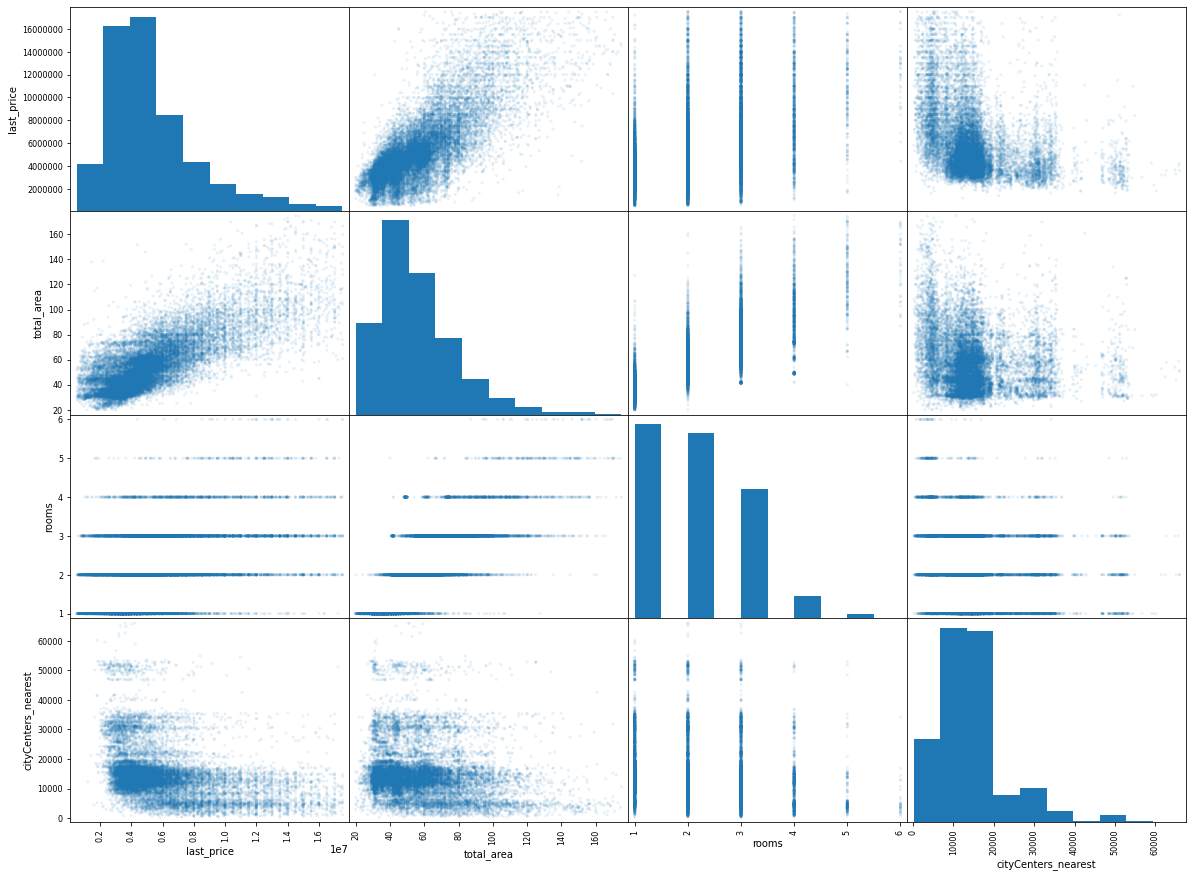

In [48]:
pd.plotting.scatter_matrix(df_filtered[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']], alpha=0.1, figsize=(20, 15))
plt.show()

In [49]:
df_filtered[['total_area', 'rooms', 'living_area', 'kitchen_area', 'cityCenters_nearest']].corrwith(df_filtered['last_price'])

total_area             0.761014
rooms                  0.487426
living_area            0.647225
kitchen_area           0.575863
cityCenters_nearest   -0.359340
dtype: float64

Из графиков видно что цена квартиры и её плошадь имеют явную прямую зависимость и довольно высокий коэффициент корреляции.

Связь между ценой квартиры и количеством комнат менее очевидна, но, тем не менее, тоже хорошо прослеживается на графике.

Наименее очевидной является связь между ценой и расположением квартиры. Тем не менее, то что коэффициент корреляции отрицателен выполне укладывается в здравый смысл.

### От этажа.

Построим диаграмму рассеяния для цены и типа этажа.

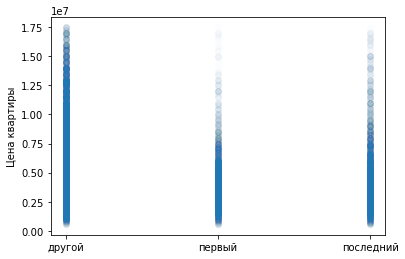

In [50]:
plt.scatter(x=df_filtered['which_floor'], y=df_filtered['last_price'], alpha=0.01)
plt.ylabel('Цена квартиры')
plt.show()

               last_price
which_floor              
другой       6.675444e+06
первый       4.820982e+06
последний    7.327011e+06


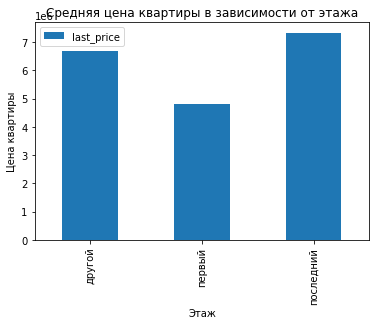

In [51]:
print(df_main.pivot_table(index='which_floor', values='last_price'))
df_main.pivot_table(index='which_floor', values='last_price').plot.bar(title='Средняя цена квартиры в зависимости от этажа')
plt.ylabel('Цена квартиры')
plt.xlabel('Этаж')
plt.show()

Из чего можно заметить, что квартиры находящиеся на "другом" шире представленны в ценовом диапазоне. Однако, квартиры на последнем этаже в среднем имеют более высокую цену чем на другом. Самыми дешевыми же в среднем являются квартиры на первом этаже.

### От даты размещения.

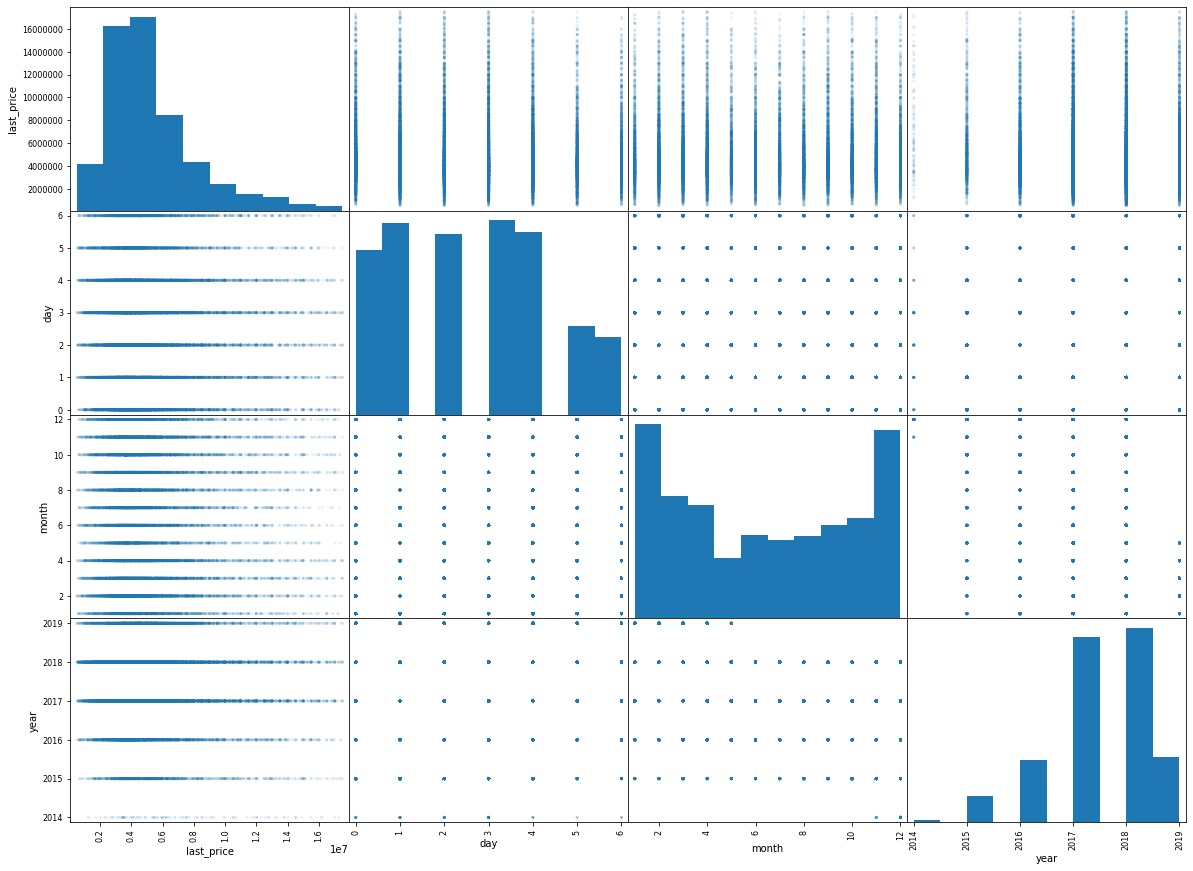

,last_price,day,month,year
last_price,1.000000,-0.018877,0.003987,-0.019719
day,-0.018877,1.000000,0.012637,-0.001442
month,0.003987,0.012637,1.000000,-0.267953
year,-0.019719,-0.001442,-0.267953,1.000000


In [52]:
pd.plotting.scatter_matrix(df_filtered[['last_price', 'day', 'month', 'year']], alpha=0.1, figsize=(20, 15))
plt.show()
df_filtered[['last_price', 'day', 'month', 'year']].corr()

Ни на графиках, ни при расчете коэффициента корреляции нельзя заметить никакой зависимости между ценой и датой размещения.

## Анализ по населенным пунктам.

Создадим список из 10 городов с самым большим количеством объявлений, и рассчитаем для него среднюю стоимость квадратного метра.

In [53]:
pivot_locality = df_filtered.pivot_table(index='locality_name', values='cost_per_square_m', aggfunc=['count', 'mean'])
pivot_locality.columns = ['count', 'mean']
top_10 = pivot_locality.sort_values(by='count', ascending=False)['mean'].head(10)
top_10

locality_name
Санкт-Петербург      108049.290390
посёлок Мурино        85725.241346
посёлок Шушары        78655.592278
Всеволожск            67161.591187
Пушкин               101744.847955
Колпино               75333.295816
посёлок Парголово     90332.262638
Гатчина               68757.678399
деревня Кудрово       92473.547559
Выборг                58027.185427
Name: mean, dtype: float64

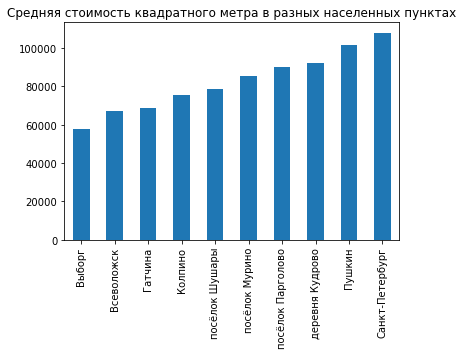

In [54]:
top_10.sort_values().plot.bar(title='Средняя стоимость квадратного метра в разных населенных пунктах')
plt.xlabel('')
plt.show()

Откуда видно, что среди 10ти наиболее широко представленных населенных пунктов наменьшая стоимость квадратного метра в Выборге, а наивысшая в Санкт-Петербурге.

## Определение центральной зоны в Санкт-Петербурге.
Отделим от основного датафрейма датафрейм Санкт-Петербурга.

In [55]:
df_spb = df_filtered.query('locality_name == "Санкт-Петербург"')
df_spb.dropna(subset=['cityCenters_nearest'], inplace=True) # отбросим все строки, в которых нет расстояния до центра
df_spb['cityCenters_nearest_km'] = round(df_spb['cityCenters_nearest']/1000) # добавим столбец с расстоянием до центра округленным до км

In [56]:
df_spb.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_square_m,day,month,year,which_floor,living_to_tot,kitchen_to_tot,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,0.47,0.23,16.0
2,10,5196000.0,56.0,2015-08-20,2,-1.00,5.0,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,0.61,0.15,14.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,0.32,0.41,8.0
7,5,7915000.0,71.6,2019-04-18,2,-1.00,24.0,40.4,22,False,False,False,18.9,2,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,110544.69,3,4,2019,другой,0.56,0.26,12.0
9,18,5400000.0,61.0,2017-02-26,3,2.50,9.0,43.6,7,False,False,False,6.5,2,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,88524.59,6,2,2017,другой,0.71,0.11,15.0


Построим график зависимости средней цены за квадратный метр от расстояния до центра города.

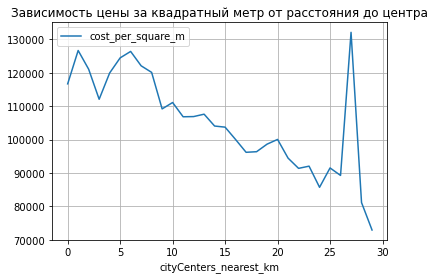

In [57]:
df_spb.pivot_table(index='cityCenters_nearest_km', values='cost_per_square_m').plot.line(grid=True, title='Зависимость цены за квадратный метр от расстояния до центра')
plt.show()

Довольно резкое падение значений на участке от 8 до 9 километра говорит о том, что граница центральной зоны пролегает через 8 километр. Дальше падение цены проходит более плавно.

Пик на 27 км обусловлен одной очень дорогой квартирой.

In [58]:
df_spb.query('cityCenters_nearest_km == 27')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_square_m,day,month,year,which_floor,living_to_tot,kitchen_to_tot,cityCenters_nearest_km
748,13,14350000.0,74.0,2017-11-28,2,3.13,5.0,30.0,3,False,False,False,25.0,0,Санкт-Петербург,23888.0,27313.0,1.0,1496.0,0.0,NaN,128.0,193918.92,1,11,2017,другой,0.41,0.34,27.0
5961,6,2250000.0,32.0,2018-02-27,1,-1.00,2.0,16.5,2,False,False,False,7.0,0,Санкт-Петербург,24006.0,27431.0,0.0,NaN,0.0,NaN,178.0,70312.50,1,2,2018,последний,0.52,0.22,27.0


## Квартиры в центре.
В качестве квартир находящихся в центре примем квартиры на расстоянии до 8 км от центра включительно. Все оставшиеся квартиры назовем периферийными.

In [59]:
df_spb_central = df_spb.query('cityCenters_nearest_km <= 8')
df_spb_not_central = df_spb.query('cityCenters_nearest_km > 8')

### Гистограммы для площади, цены, числа комнат, высоты потолков.
**Площадь**

Построим объединенную гисторамму для площади квартир в центральном и периферийном Санкт-Петербурге. Для приведения к единому масштабу переведем ось y из частоты встречаемости в плотность вероятности. То же самое проделаем и для дальнейших пунктов.

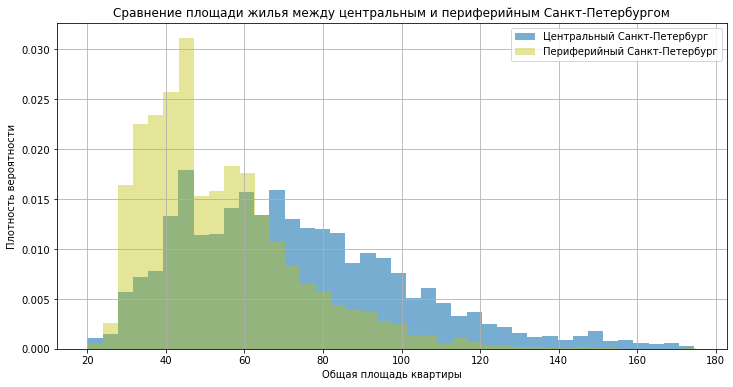

In [60]:
ax = df_spb_central.plot(kind='hist', alpha=0.6, y='total_area', label='Центральный Санкт-Петербург', bins=40, density=True)
(
    df_spb_not_central.plot(kind='hist', alpha=0.4, y='total_area', label='Периферийный Санкт-Петербург', bins=40, density=True,
                            grid=True, title='Сравнение площади жилья между центральным и периферийным Санкт-Петербургом', color='y', ax=ax, figsize=(12, 6))
)
plt.ylabel('Плотность вероятности')
plt.xlabel('Общая площадь квартиры')
plt.show()

Видно, у квартир в центре площадь более равномерна распределена. В то время как у периферийных квартир пик в области 30-50 м^2 более выражен. Из чего можно заключить, что для перифериных квартир характерна меньшая площадь, а для центральных большая.

---
**Цена**

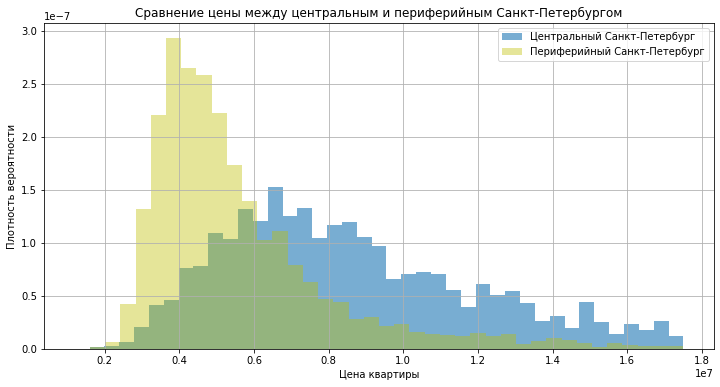

In [61]:
ax = df_spb_central.plot(kind='hist', alpha=0.6, y='last_price', label='Центральный Санкт-Петербург', bins=40, density=True)
(
    df_spb_not_central.plot(kind='hist', alpha=0.4, y='last_price', label='Периферийный Санкт-Петербург', bins=40, density=True,
                            grid=True, title='Сравнение цены между центральным и периферийным Санкт-Петербургом', color='y', ax=ax, figsize=(12, 6))
)
plt.ylabel('Плотность вероятности')
plt.xlabel('Цена квартиры')
plt.show()

Картина схожая с площадью, в среднем цены квартир в центре выше чем на периферии.

---
**Число комнат**

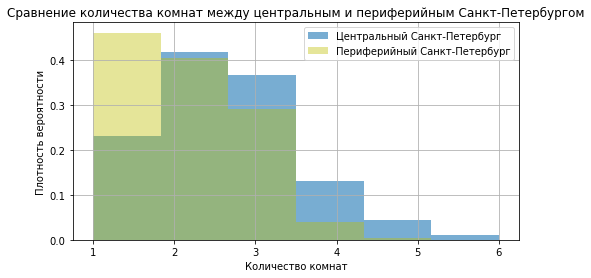

In [62]:
ax = df_spb_central.plot(kind='hist', alpha=0.6, y='rooms', label='Центральный Санкт-Петербург', bins=6, density=True)
(
    df_spb_not_central.plot(kind='hist', alpha=0.4, y='rooms', label='Периферийный Санкт-Петербург', bins=6, density=True,
                            grid=True, title='Сравнение количества комнат между центральным и периферийным Санкт-Петербургом', color='y', ax=ax, figsize=(8, 4))
)
plt.ylabel('Плотность вероятности')
plt.xlabel('Количество комнат')
plt.show()

Для центра характерны квартиры с большим числом комнат, на периферии же подавляющее число квартир являются 1-3 комнатными.

---
**Высота потолков**

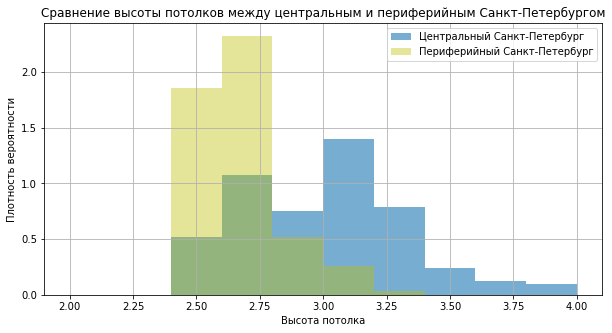

In [63]:
ax = df_spb_central.query('ceiling_height != -1').plot(kind='hist', alpha=0.6, y='ceiling_height', label='Центральный Санкт-Петербург', bins=10, density=True)
(
    df_spb_not_central.query('ceiling_height != -1')
    .plot(kind='hist', alpha=0.4, y='ceiling_height', label='Периферийный Санкт-Петербург', bins=10, density=True, 
          grid=True, title='Сравнение высоты потолков между центральным и периферийным Санкт-Петербургом', color='y', ax=ax, figsize=(10, 5))
)
plt.ylabel('Плотность вероятности')
plt.xlabel('Высота потолка')
plt.show()

Заметно, что в среднем квартиры в центре имеют большую высоту потолка, чем периферийные квартиры. Основная масса периферийных квартир имеет высоту потолка в области 2.5 - 2.75 м.
### Сравнение влияния числа комнат, этажа, удаленности от центра и даты размещения объявления на цену квартиры для квартир в центре и на периферии Санкт-Петербурга

Пострим и сравним матрицы диаграммы рассеяния для центрального и периферийного Санкт-Петербурга.

***Центр***


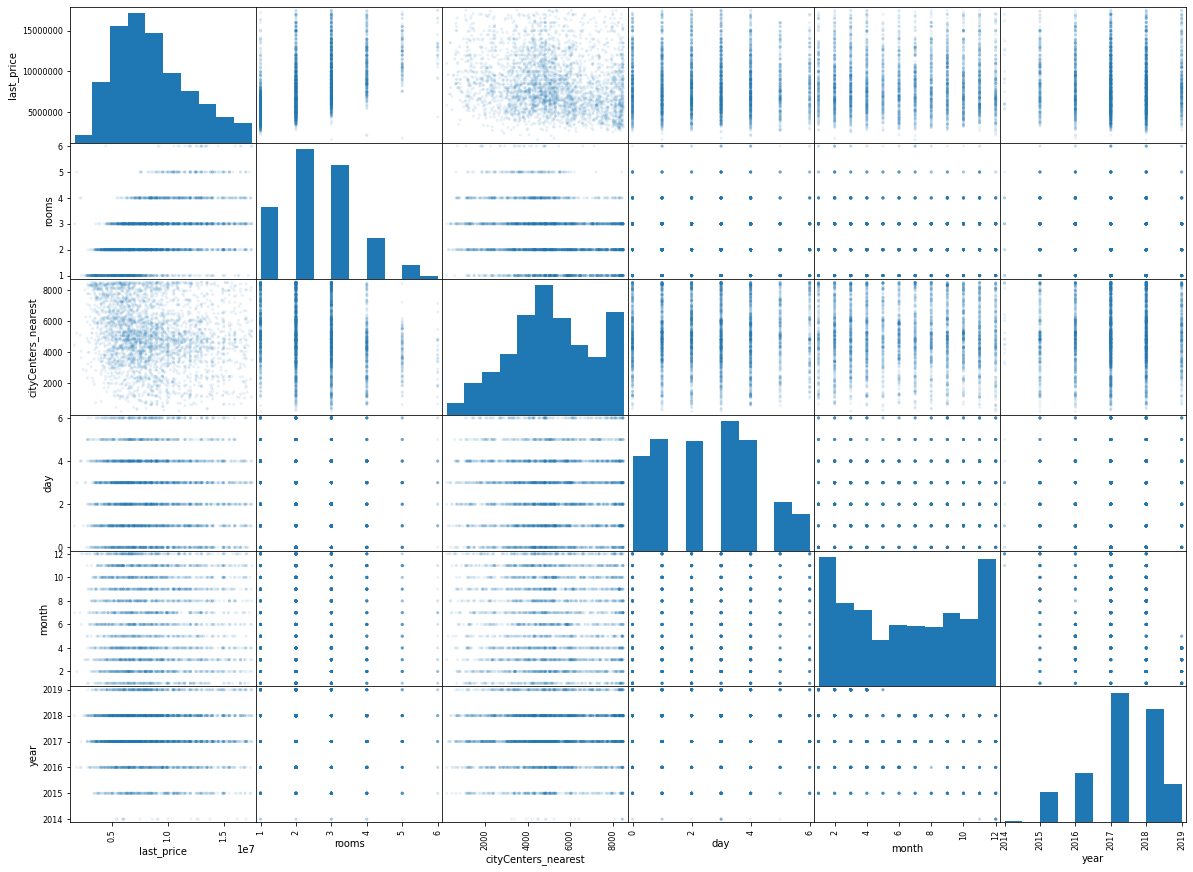

,last_price,rooms,cityCenters_nearest,day,month,year
last_price,1.000000,0.483211,-0.183442,-0.020120,-0.014877,-0.025360
rooms,0.483211,1.000000,-0.237738,-0.018109,-0.012214,-0.062131
cityCenters_nearest,-0.183442,-0.237738,1.000000,0.015742,-0.004095,0.056283
day,-0.020120,-0.018109,0.015742,1.000000,0.045785,0.016012
month,-0.014877,-0.012214,-0.004095,0.045785,1.000000,-0.235345
year,-0.025360,-0.062131,0.056283,0.016012,-0.235345,1.000000


In [64]:
pd.plotting.scatter_matrix(df_spb_central[['last_price', 'rooms', 'cityCenters_nearest', 'day', 'month', 'year']], alpha=0.1, figsize=(20, 15))
print('***Центр***')
plt.show()
df_spb_central[['last_price', 'rooms', 'cityCenters_nearest', 'day', 'month', 'year']].corr()

***Периферия***


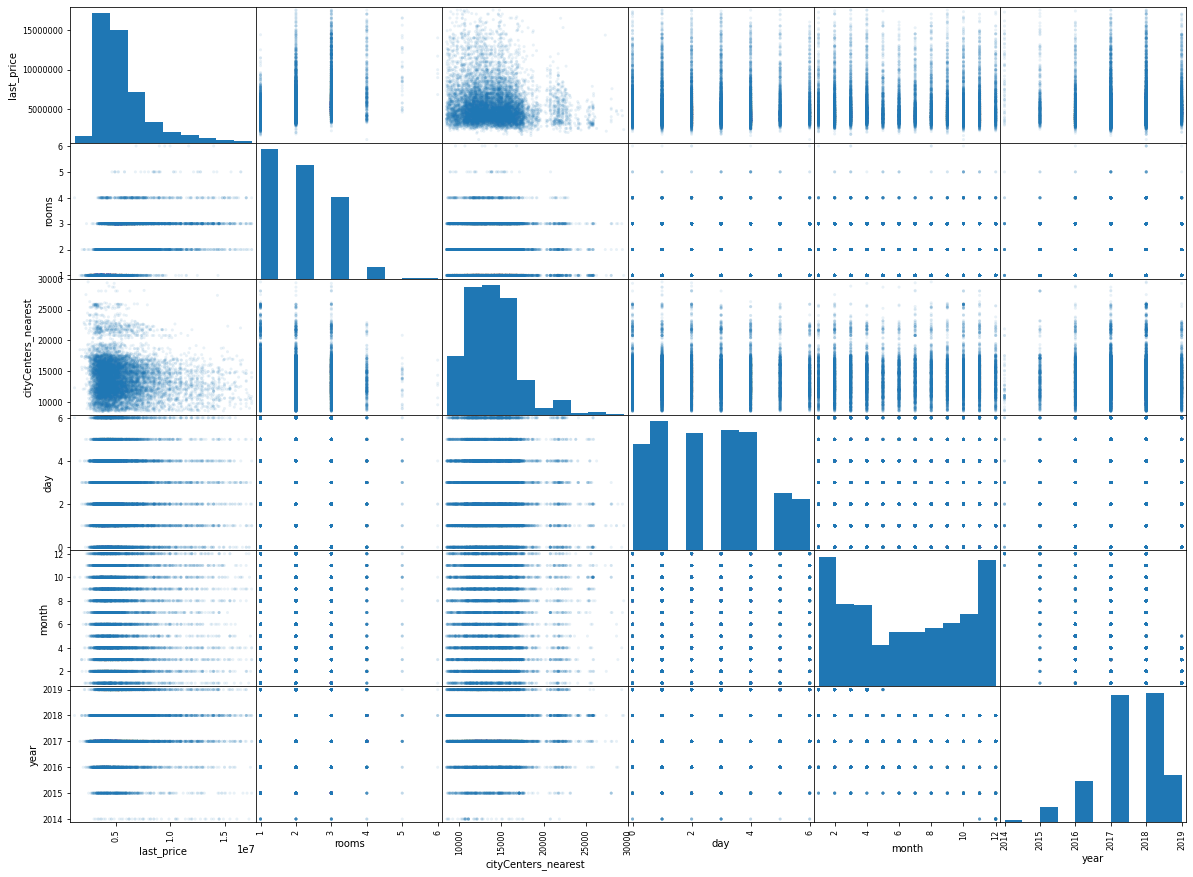

,last_price,rooms,cityCenters_nearest,day,month,year
last_price,1.000000,0.507220,-0.123106,-0.006460,-0.001280,0.046025
rooms,0.507220,1.000000,-0.039234,0.002168,-0.001220,-0.020422
cityCenters_nearest,-0.123106,-0.039234,1.000000,-0.020086,0.018887,0.011341
day,-0.006460,0.002168,-0.020086,1.000000,-0.008869,-0.002035
month,-0.001280,-0.001220,0.018887,-0.008869,1.000000,-0.289530
year,0.046025,-0.020422,0.011341,-0.002035,-0.289530,1.000000


In [65]:
pd.plotting.scatter_matrix(df_spb_not_central[['last_price', 'rooms', 'cityCenters_nearest', 'day', 'month', 'year']], alpha=0.1, figsize=(20, 15))
print('***Периферия***')
plt.show()
df_spb_not_central[['last_price', 'rooms', 'cityCenters_nearest', 'day', 'month', 'year']].corr()

В целом зависимости для центра и периферии схожи. Однако, можно заметить, что для центрального Санкт-Петерберга распределение цен от расстояния до центра выглядит значительно более раномерным. В то время как в периферии видно большое скопление в области низких цен.

Также построим диаграммы рассеяния для этажа.

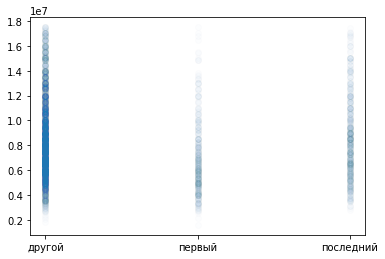

In [66]:
plt.scatter(x=df_spb_central['which_floor'], y=df_spb_central['last_price'], alpha=0.01)
plt.show()

               last_price
which_floor              
другой       8.819425e+06
первый       6.903354e+06
последний    8.518713e+06


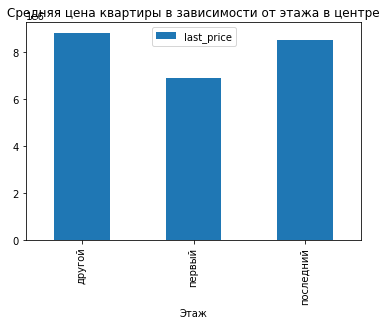

In [67]:
print(df_spb_central.pivot_table(index='which_floor', values='last_price'))
df_spb_central.pivot_table(index='which_floor', values='last_price').plot.bar(title='Средняя цена квартиры в зависимости от этажа в центре')
plt.xlabel('Этаж')
plt.show()

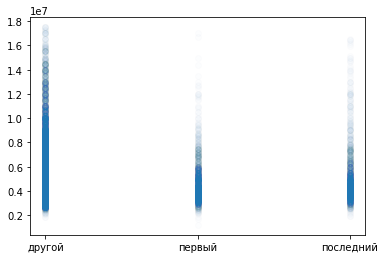

In [68]:
plt.scatter(x=df_spb_not_central['which_floor'], y=df_spb_not_central['last_price'], alpha=0.01)
plt.show()

               last_price
which_floor              
другой       5.699270e+06
первый       4.843447e+06
последний    5.241491e+06


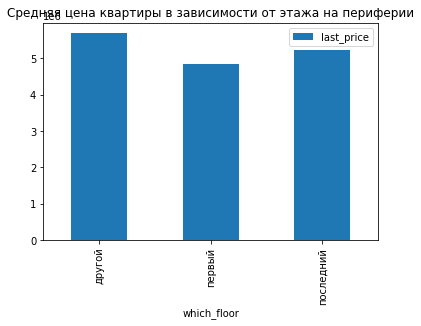

In [69]:
print(df_spb_not_central.pivot_table(index='which_floor', values='last_price'))
df_spb_not_central.pivot_table(index='which_floor', values='last_price').plot.bar(title='Средняя цена квартиры в зависимости от этажа на периферии')
plt.show()

Разницы в зависимости цены от этажа между периферией и центром не видно. 

В отличии от аналогичной гистограммы для всех населенных пунктов в Ленинградской области. Там квартиры на последнем этаже имели более высокую среднюю цену чем другие типы кварир.

# Выводы
Установлены следующие зависимости:
- Чем больше общая полощадь квартиры, тем выше её стоимость;
- Чем больше комнат, тем выше стоимость квартиры, но зависимость не столь сильна как для площади;
- Чем дальше квартира от центра тем меньше её стоимость;
- Дата размешения объявления о продаже квартиры не связана со стоимостью квартиры;
- В Санкт-Петербурге квартиры на промежуточных этажах имеют более высокую стоимость, чем квартиры на первом и последнем этаже. Квартиры на последнем этаже имеют большую стоимость чем квартиры на первом.

Сравнение квартир в центре и на периферии Санкт-Петебурга показало:
- Стомость квартир в центре более широко распределена на ценовом диапазоне, и в среднем выше чем стоимость квартир на периферии;
- Площадь квартир в центре более широко распределена на диапазоне площадей квартир, и в среднем больше чем площадь квартир на периферии;
- Среди квартир в центре чаще встречаются квартиры с большим чем на периферии числом комнат (4, 5, 6 комнат), но всё же преобладают 2 и 3-х комнатные квартиры. Среди квартир на периферии преобладают 1, 2 и реже 3-х комнатные вкартиры.
- Разнообразие различных высоких потолков у квартир в центре более широко представлено чем у квартир на периферии. Квартиры с высокими потолками в центре встречаются чаще.
- Зависимость цены от таких параметров как: количество комнат; этаж расположения квартиры; дата размещения объявления; имеют схожий характер как для квартир в центре так и и на периферии. Однако, параметр "удаленность квартиры от центра в метрах" влияет на квартиры в центре немного иначе чем на квартиры на периферии.